In [35]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [36]:
# Load in the dataset

zip_path = r"C:\Users\ncc777\Downloads\wine+quality.zip"

with zipfile.ZipFile(zip_path) as z:
    with z.open('winequality-white.csv') as f:
        white_wine = pd.read_csv(f,sep = ";")
    #zip_ref.extractall("Datasets")


    

In [37]:
df = white_wine
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [38]:
white_wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [39]:
# lets pick out the numerical columns and get the descriptions
num_features = white_wine.select_dtypes(include=['float64', 'int64']).columns
white_wine[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


In [40]:
white_wine.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

| Numeric | Category   | Meaning               |
| ------- | ---------- | --------------------- |
| 3–4     | **Low**    | Poor quality wines    |
| 5–6     | **Medium** | Average/typical wines |
| 7–8+    | **High**   | Premium-quality wines |


#### **2. EDA-Based Data Quality Assessment**

Based on EDA findings, let's assess the specific issues identified

In [41]:
def map_quality_category(x):
    if x <= 4:
        return 'Low'
    elif x <= 6:
        return 'Medium'
    else:
        return 'High'

# lets apply our function
white_wine['quality_label'] = white_wine['quality'].apply(map_quality_category)


In [42]:
white_wine.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,Medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,Medium


In [43]:
# Lets make a copy of our data
df = white_wine.copy()

----------------------------------------------------------------
 ### **1. Univariate analysis**
 ---------------------------------------------------------------

In [44]:

def univariate_numerical_eda(df, column):
    """
    Performs univariate EDA on a single numerical column.
    Displays summary statistics, skewness, kurtosis, histogram, KDE, and boxplot.
    """
    print(f" Feature: {column}")
    print("="*40)
    print(df[column].describe().to_frame())
    print(f"\nSkewness: {df[column].skew():.3f}")
    print(f"Kurtosis: {df[column].kurt():.3f}")

    plt.figure(figsize=(12,4))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[column], kde=True, bins=30, color='teal')
    plt.title(f'\n Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[column], color='teal')
    plt.title(f'\n Boxplot of {column}', fontsize=13)

    plt.tight_layout()
    plt.show()

    # Optional note on transformation
    if abs(df[column].skew()) > 1:
        print(f"\n {column} is highly skewed. Consider log or Box-Cox transformation.")
    elif abs(df[column].skew()) > 0.5:
        print(f"{column} is moderately skewed.")
    else:
        print(f"{column} is fairly symmetric.")


 Feature: fixed acidity
       fixed acidity
count    4898.000000
mean        6.854788
std         0.843868
min         3.800000
25%         6.300000
50%         6.800000
75%         7.300000
max        14.200000

Skewness: 0.648
Kurtosis: 2.172


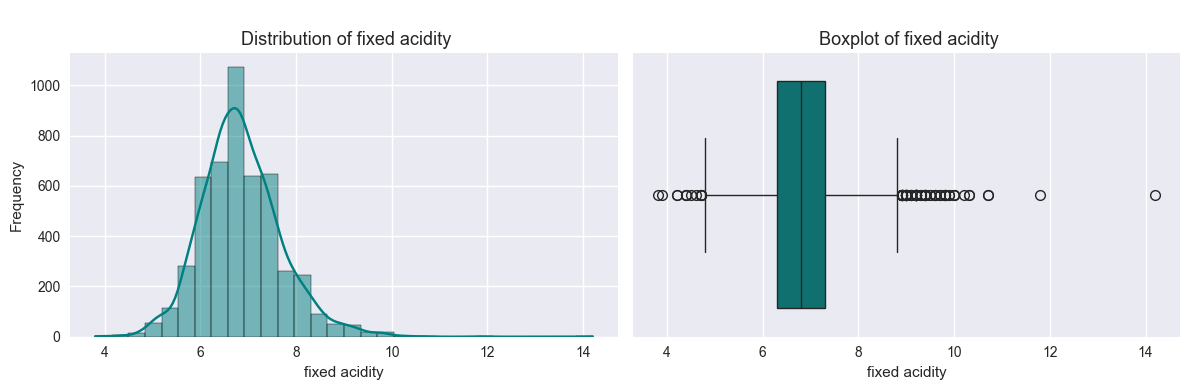

fixed acidity is moderately skewed.
 Feature: volatile acidity
       volatile acidity
count       4898.000000
mean           0.278241
std            0.100795
min            0.080000
25%            0.210000
50%            0.260000
75%            0.320000
max            1.100000

Skewness: 1.577
Kurtosis: 5.092


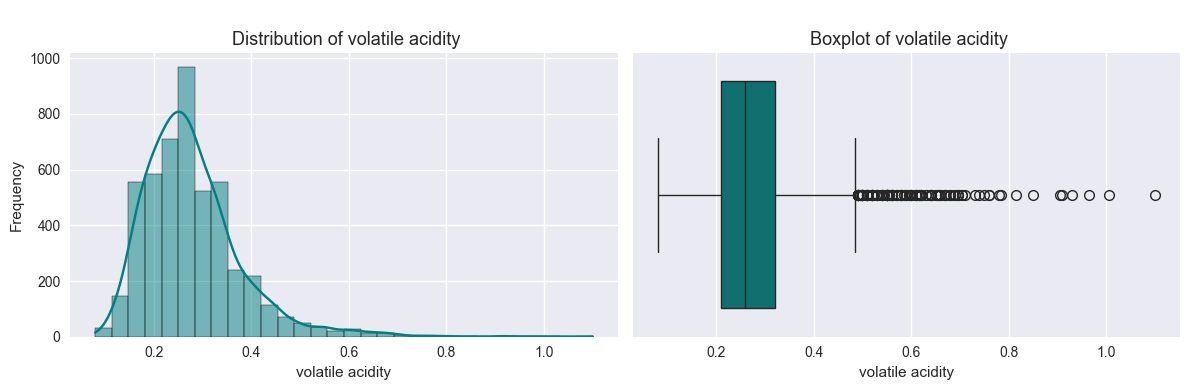


 volatile acidity is highly skewed. Consider log or Box-Cox transformation.
 Feature: citric acid
       citric acid
count  4898.000000
mean      0.334192
std       0.121020
min       0.000000
25%       0.270000
50%       0.320000
75%       0.390000
max       1.660000

Skewness: 1.282
Kurtosis: 6.175


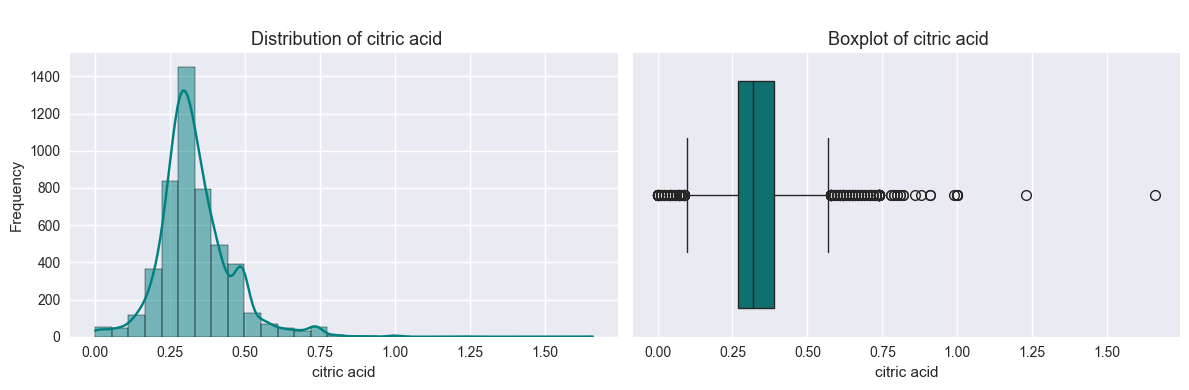


 citric acid is highly skewed. Consider log or Box-Cox transformation.
 Feature: residual sugar
       residual sugar
count     4898.000000
mean         6.391415
std          5.072058
min          0.600000
25%          1.700000
50%          5.200000
75%          9.900000
max         65.800000

Skewness: 1.077
Kurtosis: 3.470


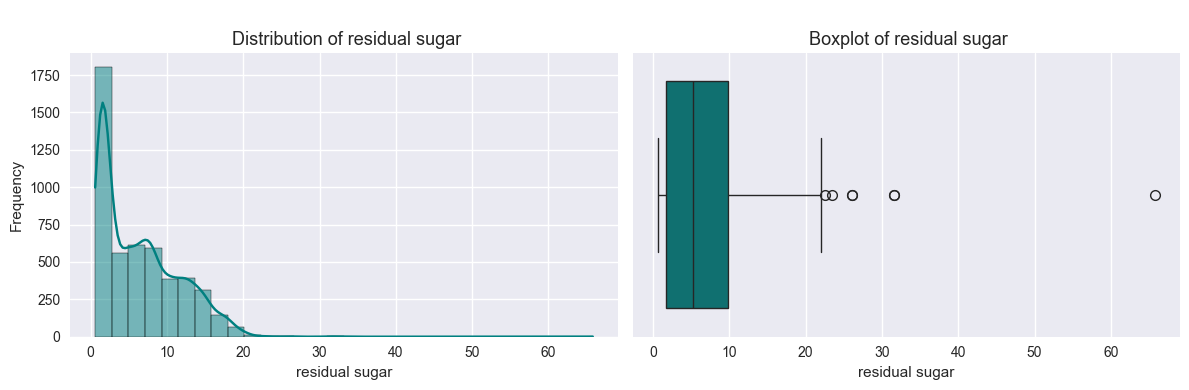


 residual sugar is highly skewed. Consider log or Box-Cox transformation.
 Feature: chlorides
         chlorides
count  4898.000000
mean      0.045772
std       0.021848
min       0.009000
25%       0.036000
50%       0.043000
75%       0.050000
max       0.346000

Skewness: 5.023
Kurtosis: 37.565


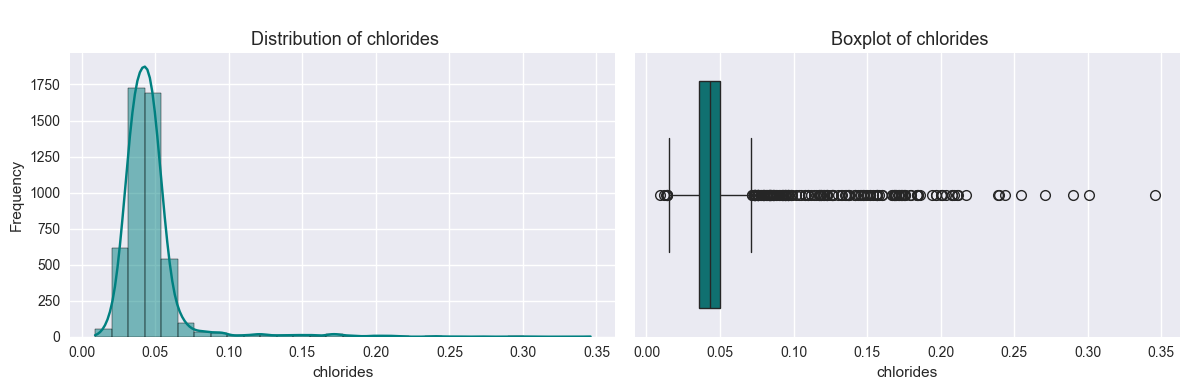


 chlorides is highly skewed. Consider log or Box-Cox transformation.
 Feature: free sulfur dioxide
       free sulfur dioxide
count          4898.000000
mean             35.308085
std              17.007137
min               2.000000
25%              23.000000
50%              34.000000
75%              46.000000
max             289.000000

Skewness: 1.407
Kurtosis: 11.466


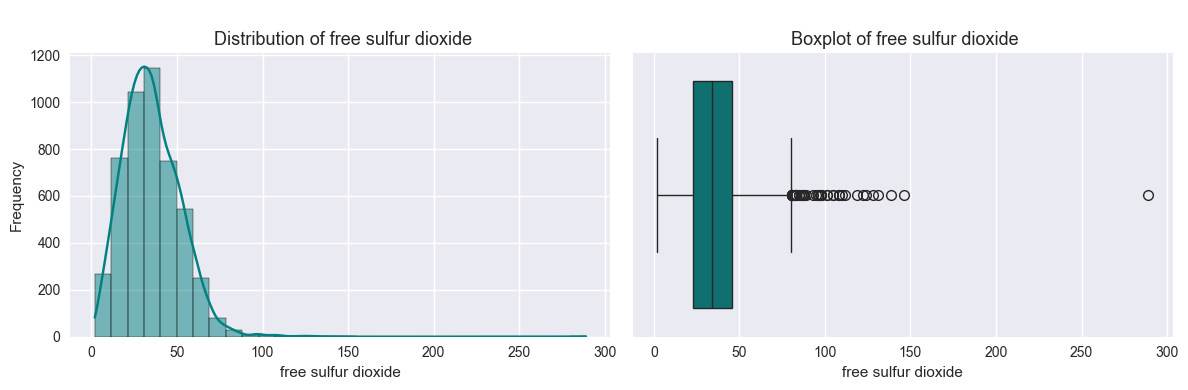


 free sulfur dioxide is highly skewed. Consider log or Box-Cox transformation.
 Feature: total sulfur dioxide
       total sulfur dioxide
count           4898.000000
mean             138.360657
std               42.498065
min                9.000000
25%              108.000000
50%              134.000000
75%              167.000000
max              440.000000

Skewness: 0.391
Kurtosis: 0.572


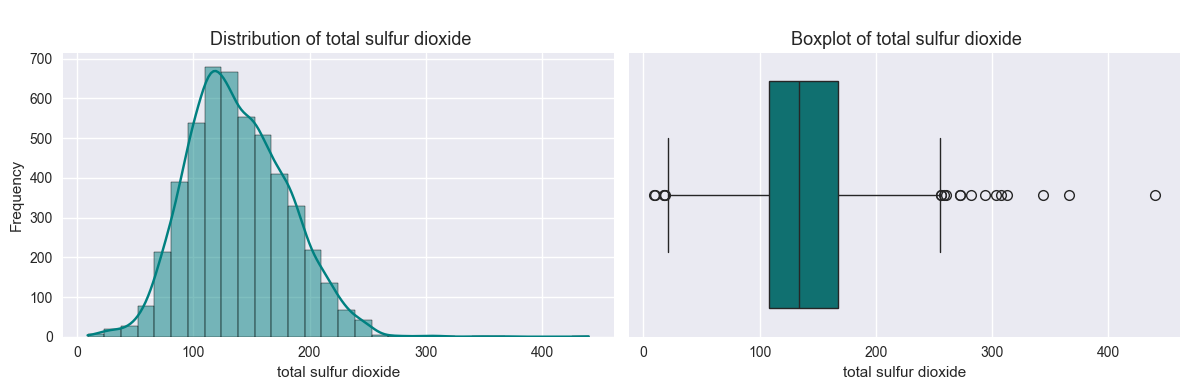

total sulfur dioxide is fairly symmetric.
 Feature: density
           density
count  4898.000000
mean      0.994027
std       0.002991
min       0.987110
25%       0.991723
50%       0.993740
75%       0.996100
max       1.038980

Skewness: 0.978
Kurtosis: 9.794


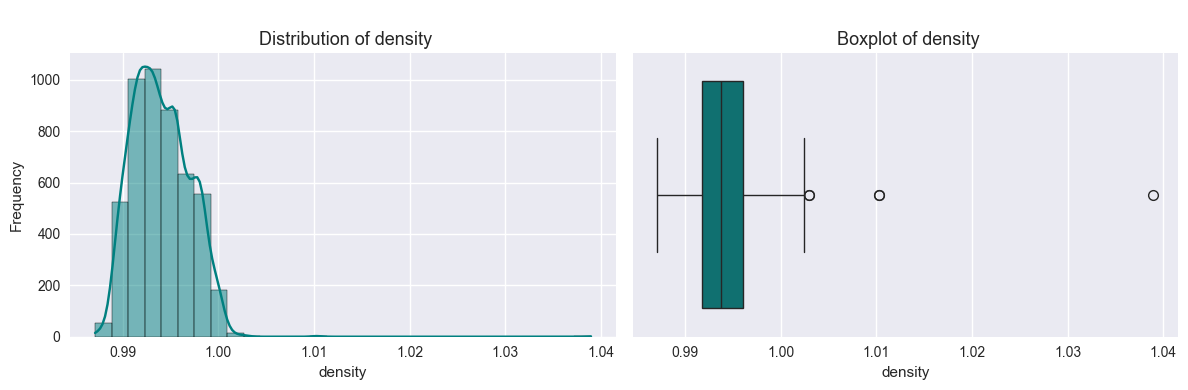

density is moderately skewed.
 Feature: pH
                pH
count  4898.000000
mean      3.188267
std       0.151001
min       2.720000
25%       3.090000
50%       3.180000
75%       3.280000
max       3.820000

Skewness: 0.458
Kurtosis: 0.531


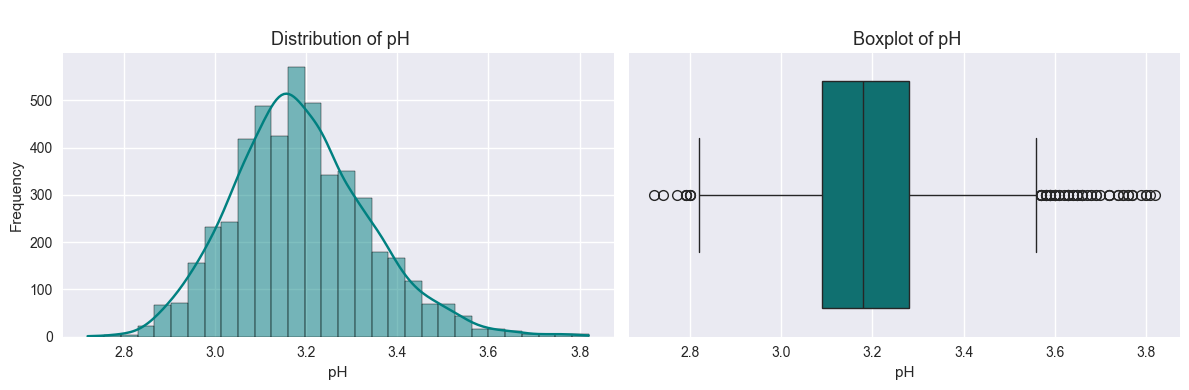

pH is fairly symmetric.
 Feature: sulphates
         sulphates
count  4898.000000
mean      0.489847
std       0.114126
min       0.220000
25%       0.410000
50%       0.470000
75%       0.550000
max       1.080000

Skewness: 0.977
Kurtosis: 1.591


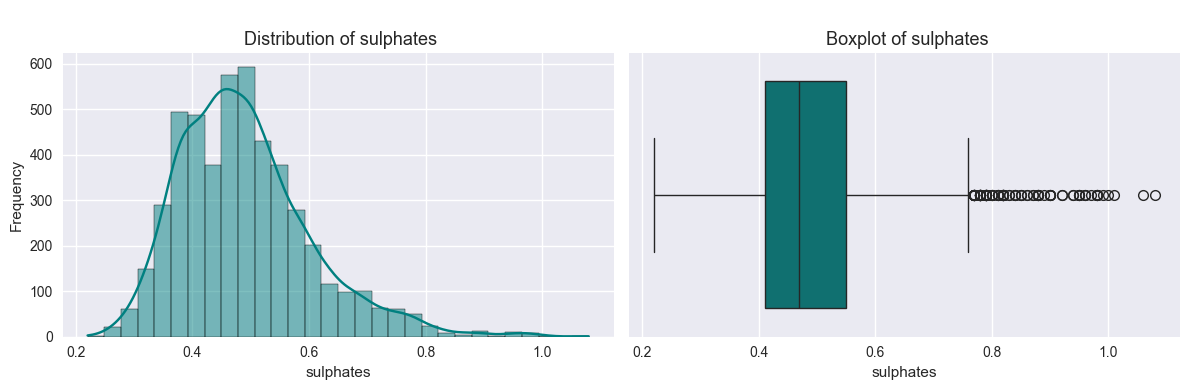

sulphates is moderately skewed.
 Feature: alcohol
           alcohol
count  4898.000000
mean     10.514267
std       1.230621
min       8.000000
25%       9.500000
50%      10.400000
75%      11.400000
max      14.200000

Skewness: 0.487
Kurtosis: -0.698


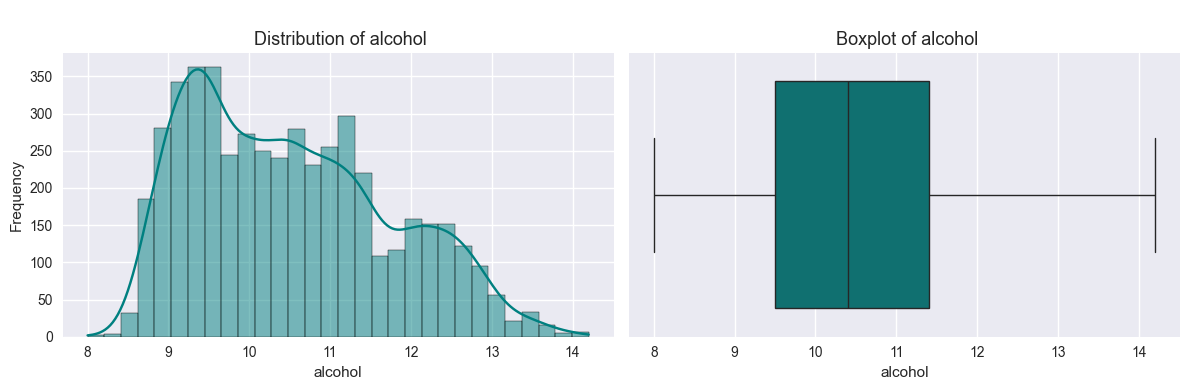

alcohol is fairly symmetric.
 Feature: quality
           quality
count  4898.000000
mean      5.877909
std       0.885639
min       3.000000
25%       5.000000
50%       6.000000
75%       6.000000
max       9.000000

Skewness: 0.156
Kurtosis: 0.217


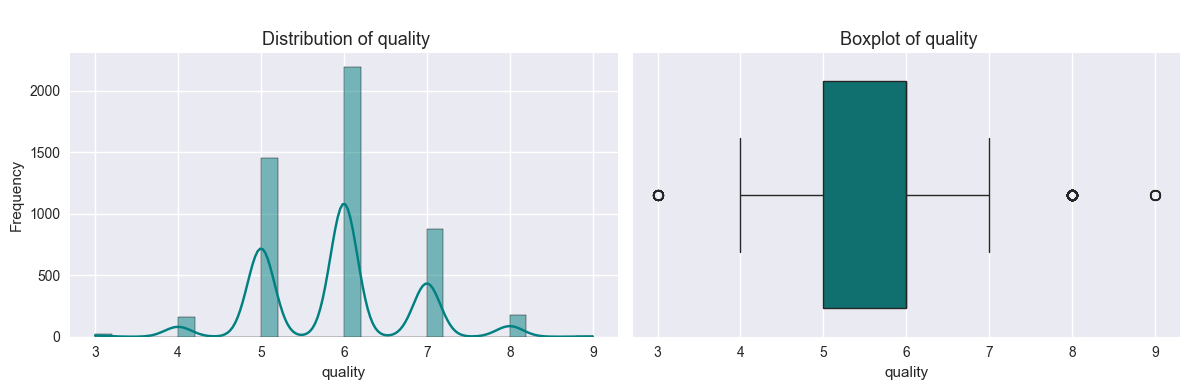

quality is fairly symmetric.


In [45]:
# We can loop to save time
for col in num_features:
    univariate_numerical_eda(df, col)

In [46]:

def univariate_categorical_eda(df, column):
    """
    Performs univariate EDA on a categorical or ordinal column.
    Displays frequency table, proportion, and a countplot.
    """
    print(f"Feature: {column}")
    print("="*40)

    # Frequency + proportion
    freq = df[column].value_counts()
    prop = df[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Count': freq, 'Percentage': prop.round(2)})
    print(summary)
    print()

    # Visualization
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x=column, data=df, palette='Set2', order=freq.index,color='teal')
    plt.title(f'Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Count')

    # Annotate each bar with percentage
    total = len(df[column])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 1,
                f'{(height/total)*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

In [47]:
cat_features = white_wine.select_dtypes(include=['object']).columns
cat_features

Index(['quality_label'], dtype='object')

Feature: quality_label
               Count  Percentage
quality_label                   
Medium          3655       74.62
High            1060       21.64
Low              183        3.74



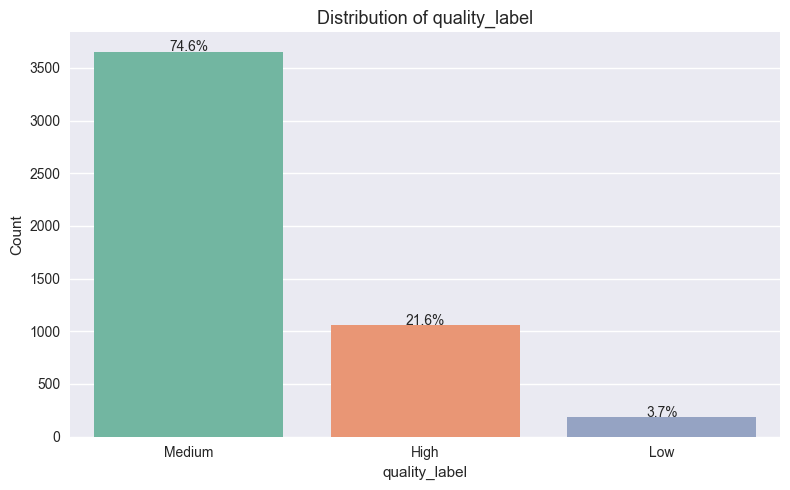

In [48]:
# We can loop to save time
for col in cat_features:
    univariate_categorical_eda(df, col)

Correlation with target

In [49]:
def correlation_with_target(df, target_col, figsize=(10,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a Series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include='number').copy()
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")

    # compute correlations of every numeric column with the target
    corrs = numeric_df.corrwith(numeric_df[target_col]).drop(target_col)

    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

    # return sorted correlations for downstream use
    return corrs.reindex(corrs.abs().sort_values(ascending=False).index)


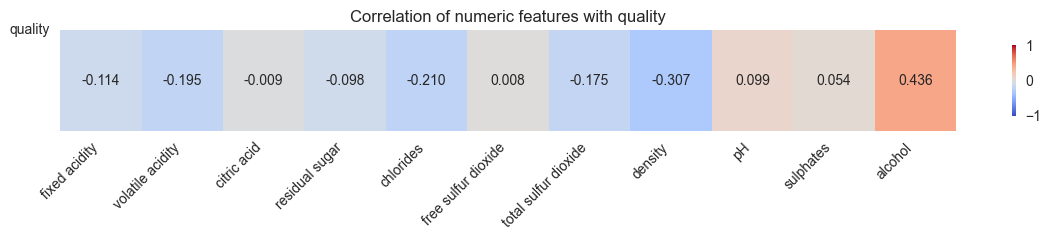

alcohol                 0.435575
density                -0.307123
chlorides              -0.209934
volatile acidity       -0.194723
total sulfur dioxide   -0.174737
fixed acidity          -0.113663
pH                      0.099427
residual sugar         -0.097577
sulphates               0.053678
citric acid            -0.009209
free sulfur dioxide     0.008158
dtype: float64


In [50]:
corr_series = correlation_with_target(df, 'quality', figsize=(12,2.5))
print(corr_series) 

In [51]:
num_features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [52]:
from scipy.stats import pearsonr

def numeric_bivariate_plot(df, x_col, y_col):
    """
    Plots the relationship between two numeric variables with a regression line
    and displays the correlation coefficient.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the numeric columns
    x_col : str
        Name of the first numeric variable (x-axis)
    y_col : str
        Name of the second numeric variable (y-axis)
    """

    # Calculate correlation coefficient
    corr, p_value = pearsonr(df[x_col], df[y_col])

    # Create plot
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    # Title and labels
    plt.title(f"{y_col} vs {x_col}\nCorrelation: {corr:.3f} (p={p_value:.3f})", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    plt.show()


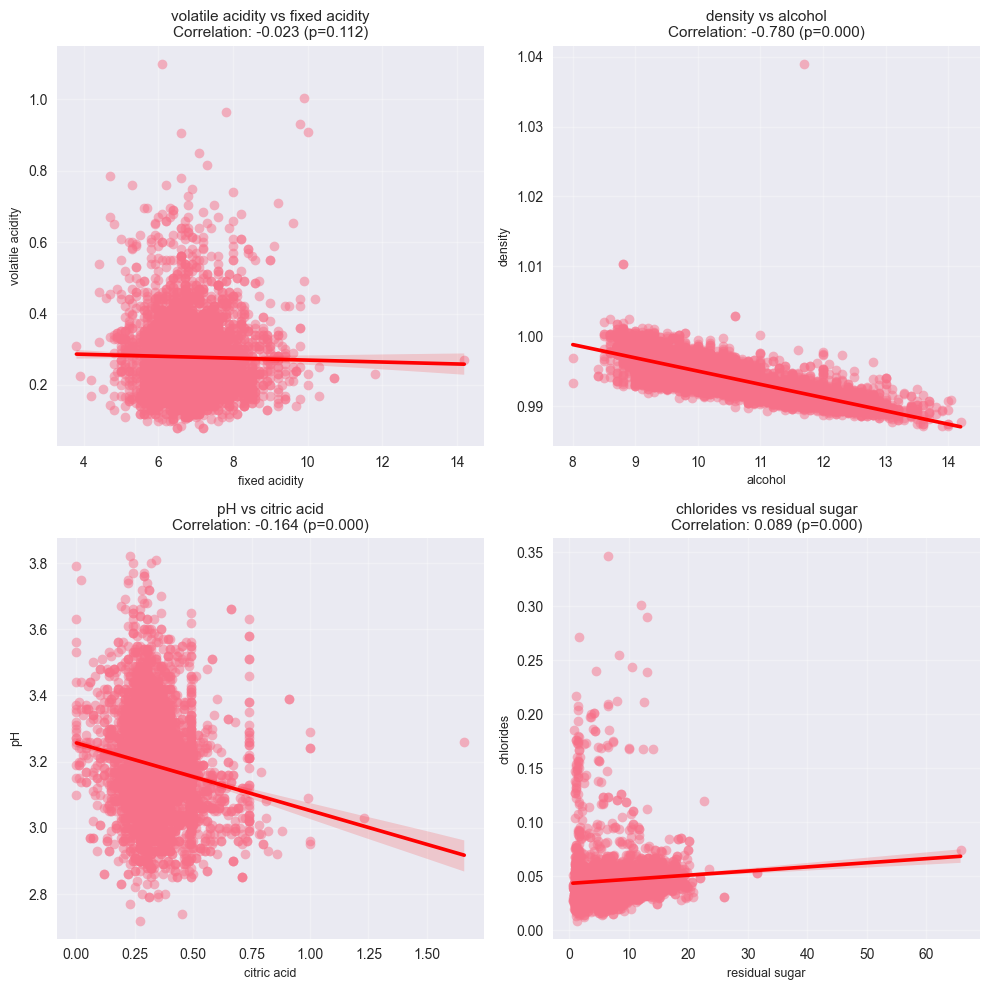

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def numeric_bivariate_plot(df, pairs):
    """
    Plots the relationship between multiple pairs of numeric variables in a single figure,
    with each subplot showing the correlation coefficient and regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the numeric columns
    pairs : list of tuples
        List containing tuples of column names to be compared (x_col, y_col)
    """
    # Define the grid size for subplots
    num_pairs = len(pairs)
    cols = 2  # Number of columns for subplots (can adjust)
    rows = (num_pairs // cols) + (num_pairs % cols > 0)  # Calculate number of rows

    # Create the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    # Flatten axes to iterate easily
    axes = axes.flatten()

    # Loop through the pairs and create each plot
    for i, (x_col, y_col) in enumerate(pairs):
        # Calculate correlation coefficient
        corr, p_value = pearsonr(df[x_col], df[y_col])

        # Create the bivariate plot
        sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ax=axes[i])

        # Title and labels for each subplot
        axes[i].set_title(f"{y_col} vs {x_col}\nCorrelation: {corr:.3f} (p={p_value:.3f})", fontsize=11)
        axes[i].set_xlabel(x_col, fontsize=9)
        axes[i].set_ylabel(y_col, fontsize=9)
        axes[i].grid(alpha=0.3)

    # Remove empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
pairs = [
    ('fixed acidity', 'volatile acidity'),
    ('alcohol', 'density'),
    ('citric acid', 'pH'),
    ('residual sugar', 'chlorides')  # Add as many pairs as you want to compare
]
numeric_bivariate_plot(df, pairs)


**Numeric–Categorical (Feature vs Target)**

In [54]:
def bivariate_num_cat(df, feature, target='quality_label'):
    """
    Plots and summarizes relationship between a numerical feature and a categorical target.
    """
    print(f" Feature: {feature} vs {target}")
    print("="*50)

    # Group summary
    summary = df.groupby(target)[feature].describe()[['mean','std','min','max']]
    print(summary)
    print()

    plt.figure(figsize=(10,5))

    # Boxplot + mean line
    sns.boxplot(x=target, y=feature, data=df, palette='Set2')
    plt.title(f'{feature} across {target} categories', fontsize=13)
    plt.xlabel(target)
    plt.ylabel(feature)
    plt.show()

    # # Violin plot for distribution shape
    # plt.figure(figsize=(10,5))
    # sns.violinplot(x=target, y=feature, data=df, palette='Set3')
    # plt.title(f'{feature} distribution by {target}', fontsize=13)
    # plt.xlabel(target)
    # plt.ylabel(feature)
    # plt.show()


 Feature: fixed acidity vs quality_label
                   mean       std  min   max
quality_label                               
High           6.725142  0.768798  3.9   9.2
Low            7.180874  1.171885  4.2  11.8
Medium         6.876060  0.839049  3.8  14.2



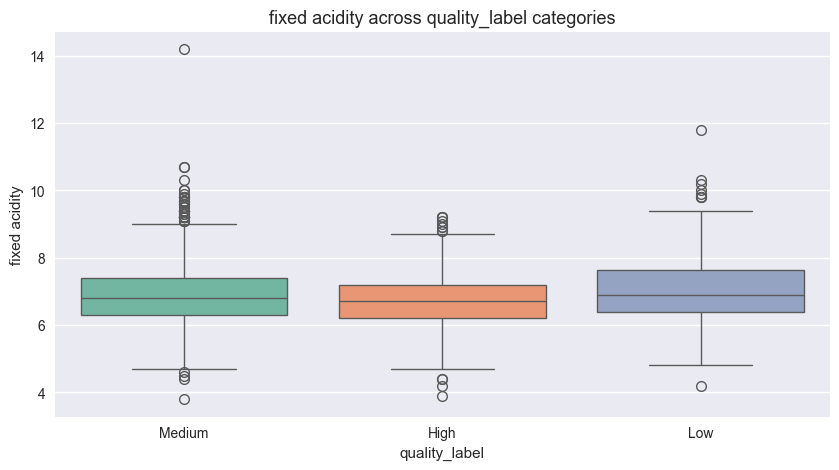

In [55]:
bivariate_num_cat(df, "fixed acidity", target='quality_label')

Feature: fixed acidity vs quality_label
                   mean       std  min   max
quality_label                               
High           6.725142  0.768798  3.9   9.2
Low            7.180874  1.171885  4.2  11.8
Medium         6.876060  0.839049  3.8  14.2

Feature: alcohol vs quality_label
                    mean       std  min   max
quality_label                                
High           11.416022  1.255209  8.5  14.2
Low            10.173497  1.027570  8.0  13.5
Medium         10.269808  1.104035  8.0  14.0

Feature: citric acid vs quality_label
                   mean       std   min   max
quality_label                                
High           0.326057  0.080288  0.01  0.74
Low            0.307705  0.157131  0.00  0.88
Medium         0.337877  0.128304  0.00  1.66

Feature: residual sugar vs quality_label
                   mean       std  min    max
quality_label                                
High           5.261509  4.290845  0.8  19.25
Low            4.8210

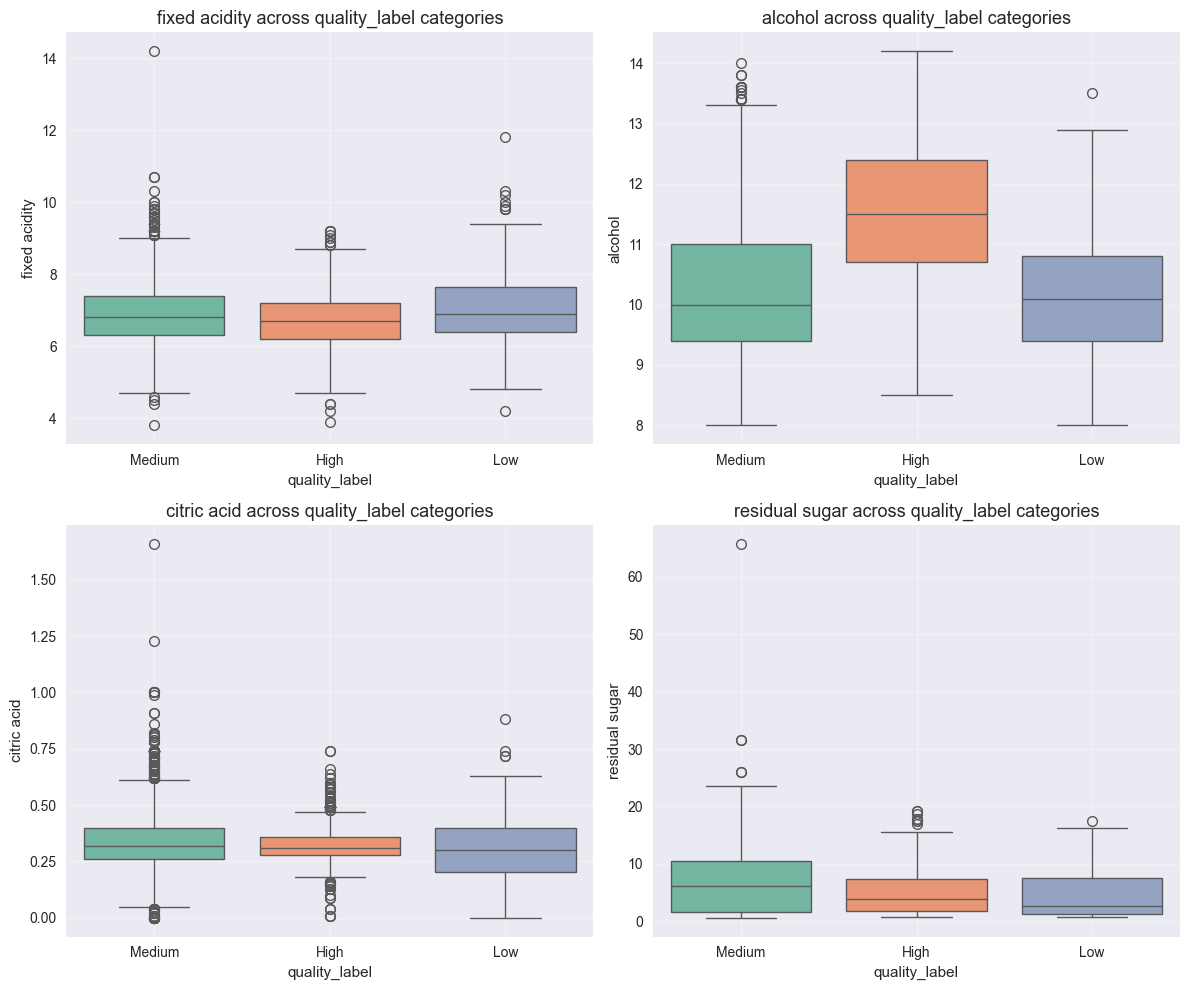

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def bivariate_num_cat(df, features, target='quality_label'):
    """
    Plots and summarizes the relationship between multiple numerical features and a categorical target.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the numeric and categorical columns
    features : list of str
        List of numerical features to be compared
    target : str
        Name of the categorical target variable (default is 'quality_label')
    """
    
    num_features = len(features)
    cols = 2  # Number of columns for subplots (adjustable)
    rows = (num_features // cols) + (num_features % cols > 0)  # Calculate number of rows
    
    # Create subplots grid
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))

    # Flatten axes to easily loop through them
    axes = axes.flatten()

    # Loop through features and create a boxplot for each
    for i, feature in enumerate(features):
        print(f"Feature: {feature} vs {target}")
        print("="*50)
        
        # Group summary for the feature against the target
        summary = df.groupby(target)[feature].describe()[['mean', 'std', 'min', 'max']]
        print(summary)
        print()

        # Create a boxplot on the corresponding subplot
        sns.boxplot(x=target, y=feature, data=df, palette='Set2', ax=axes[i])
        axes[i].set_title(f'{feature} across {target} categories', fontsize=13)
        axes[i].set_xlabel(target, fontsize=11)
        axes[i].set_ylabel(feature, fontsize=11)
        axes[i].grid(True, alpha=0.3)

    # Remove empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage:
features = ['fixed acidity', 'alcohol', 'citric acid', 'residual sugar']  # List of numerical features
bivariate_num_cat(df, features, target='quality_label')


----------------------------------------------------------------
 ### **3. Trivariate analysis**
 ---------------------------------------------------------------

In [57]:
def trivariate_plot(df, x_col, y_col, hue_col):
    """
    Visualizes the relationship between two numeric variables
    with a third categorical variable shown by color (hue).
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset.
    x_col : str
        The first numeric feature (x-axis).
    y_col : str
        The second numeric feature (y-axis).
    hue_col : str
        The categorical feature (color grouping).
    """

    plt.figure(figsize=(8, 6))
    sns.lmplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue=hue_col, 
        height=6, 
        aspect=1.2, 
        scatter_kws={'alpha':0.6}, 
        line_kws={'linewidth':2}
    )
    plt.title(f"{y_col} vs {x_col} by {hue_col}", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    plt.show()


<Figure size 800x600 with 0 Axes>

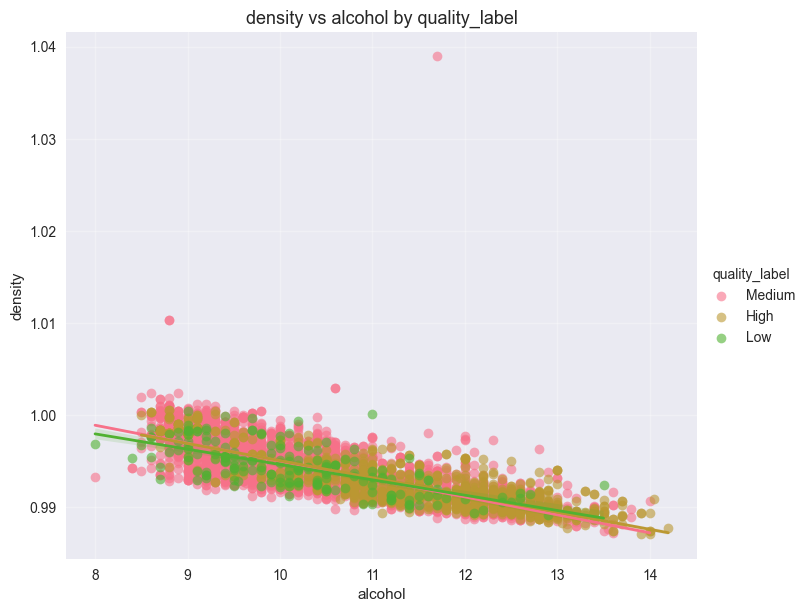

In [58]:
trivariate_plot(df, 'alcohol', 'density', 'quality_label')

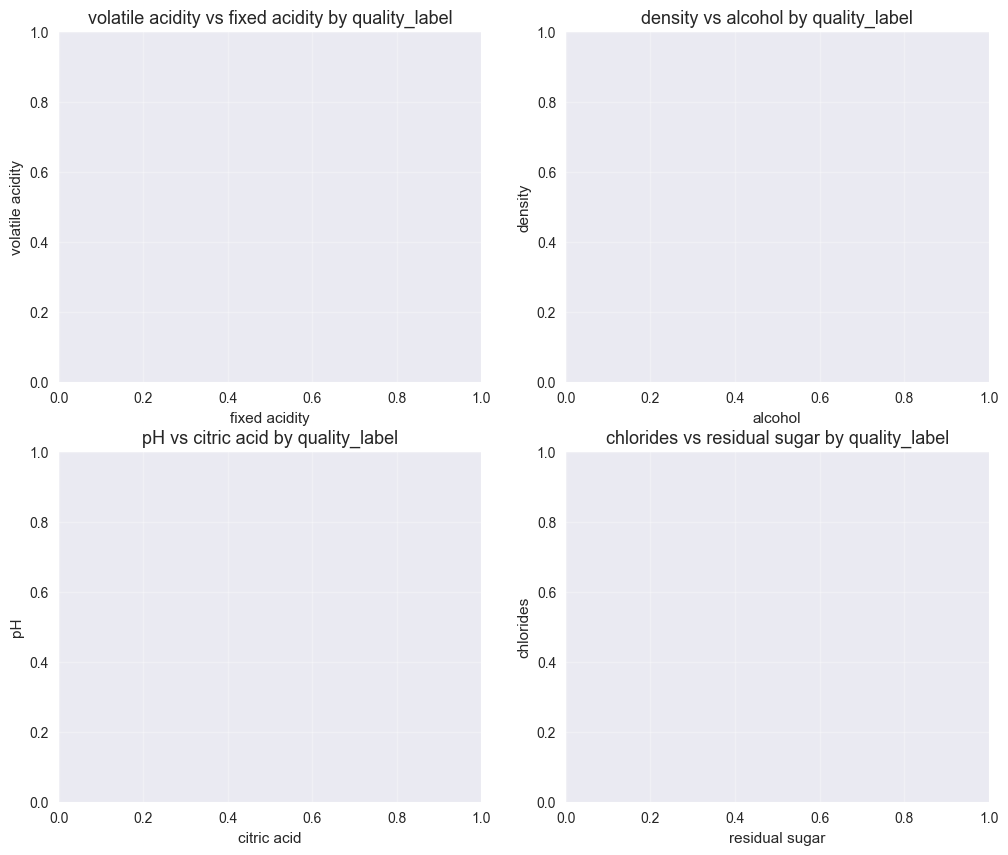

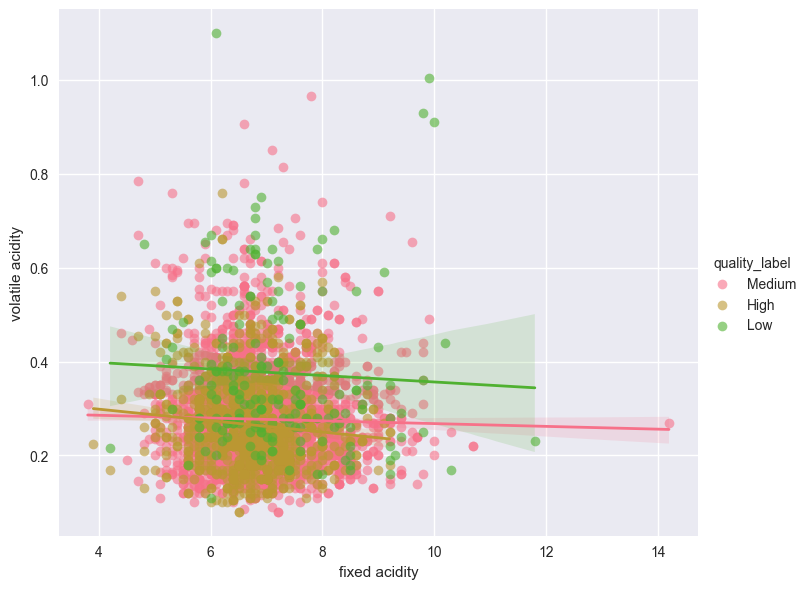

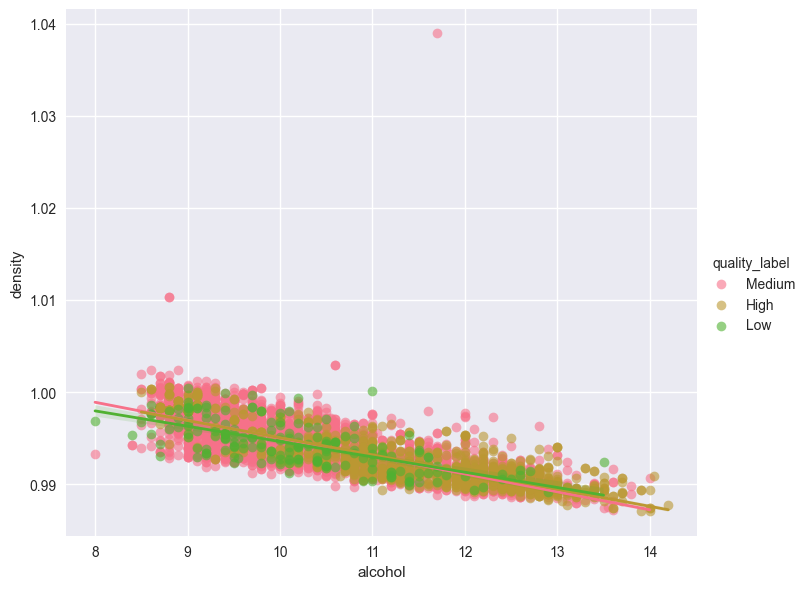

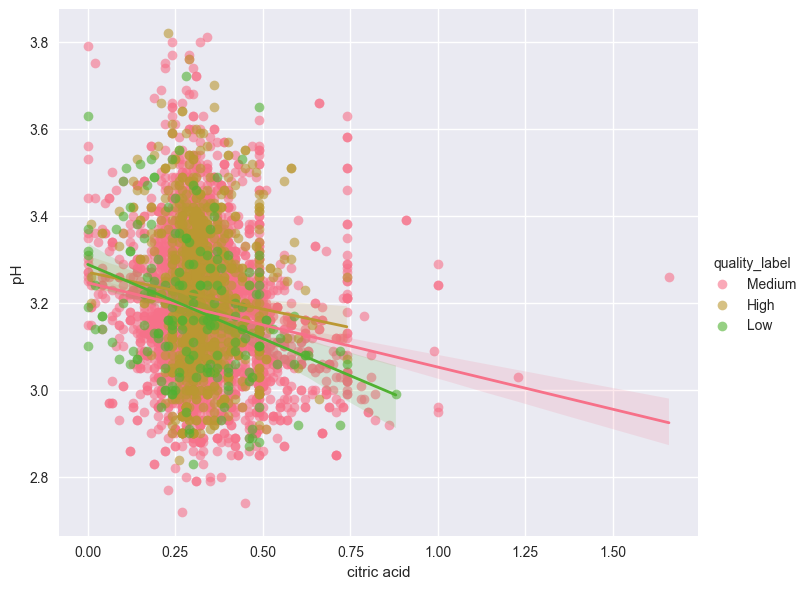

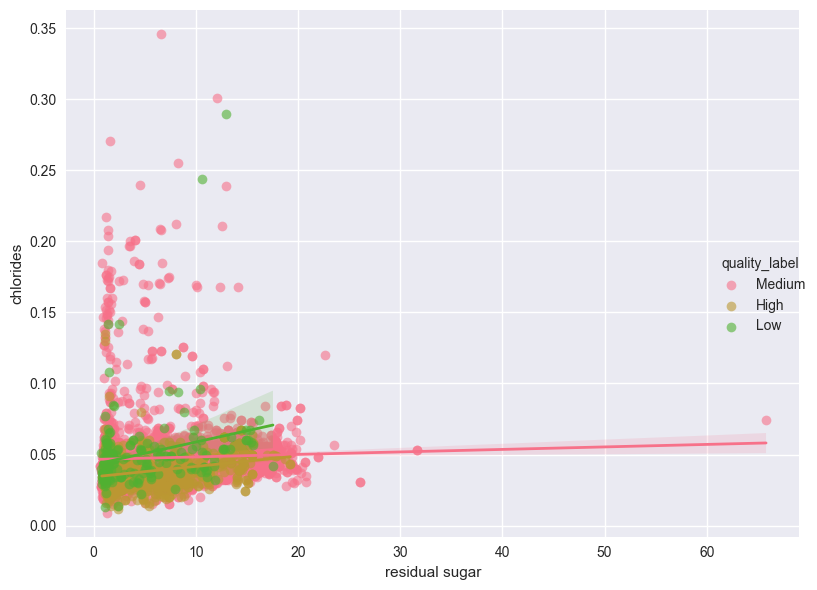

In [59]:
def trivariate_plot(df, pairs, hue_col):
    """
    Visualizes the relationships between multiple pairs of numeric variables
    with a third categorical variable shown by color (hue), all in one figure.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset.
    pairs : list of tuples
        List of pairs of numeric features to be compared (x_col, y_col).
    hue_col : str
        The categorical feature (color grouping).
    """
    
    num_pairs = len(pairs)
    cols = 2  # Number of columns for subplots (can adjust)
    rows = (num_pairs // cols) + (num_pairs % cols > 0)  # Calculate number of rows

    # Create a figure with subplots grid (without ax argument here)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))

    # Flatten axes to easily loop through them
    axes = axes.flatten()

    # Loop through the pairs and create a trivariate plot for each
    for i, (x_col, y_col) in enumerate(pairs):
        # Create the trivariate plot (scatter with regression line)
        sns.lmplot(
            data=df, 
            x=x_col, 
            y=y_col, 
            hue=hue_col, 
            height=6, 
            aspect=1.2, 
            scatter_kws={'alpha': 0.6}, 
            line_kws={'linewidth': 2}
        )

        # Customize the subplot
        axes[i].set_title(f"{y_col} vs {x_col} by {hue_col}", fontsize=13)
        axes[i].set_xlabel(x_col, fontsize=11)
        axes[i].set_ylabel(y_col, fontsize=11)
        axes[i].grid(True, alpha=0.3)

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
pairs = [
    ('fixed acidity', 'volatile acidity'),
    ('alcohol', 'density'),
    ('citric acid', 'pH'),
    ('residual sugar', 'chlorides')  # Add as many pairs as you want
]
trivariate_plot(df, pairs, hue_col='quality_label')


 ##### **3. Multivariate analysis**

In [60]:
def grouped_summary(df):
    """
    Computes summary statistics grouped by wine quality.
    """
    summary = df.groupby('quality').mean(numeric_only=True).round(2)
    return summary


In [61]:
num_features = pd.DataFrame(white_wine[num_features])
num_features.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


In [62]:
num_features.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')